## **Temperature inversion strength model**

$C_v \frac{\Delta T}{dt} = Q_i - \lambda \Delta T - \rho c_p \left( \frac{k}{\log\frac{z_r}{z_0}}\right)^2 U \Delta T f(\Delta T)$

In [1]:
import numpy as np
import sdeint
from matplotlib import pyplot as plt
import scipy.integrate as integrate
import seaborn as sns
import scipy.stats
from matplotlib.ticker import FormatStrFormatter

%matplotlib inline

In [24]:
# Parameters for Dome C, Antarctica

q = 50        # isothermal net radiation
l = 2         # lumped parameter
U = 5.32       # wind speed
rho = 1.0     # air density
c_p = 1005    # heat capacity of air
k = 0.4       # Kármán constant
g = 9.81      # gravitational constant
T_r = 243     # temparature in reference height
z_r = 10      # reference height
z_0 = 0.01    # temperature measure point above surface  
c_v = 1000    # heat capacity
alpha = 5 

c_D = pow((k/np.log(z_r/z_0)),2)
C =  2 * alpha * z_r * g/T_r

#### **Model functions**

In [25]:
# short-tail function
def fst(x):
    return q - l*x - rho * c_p * c_D * U * x * np.exp(-C * x/pow(U,2) - pow((C * x/(2*pow(U,2))),2))

# long-tail function
def flt(x):
    return q - l*x - rho * c_p * c_D * U * x * np.exp(-C * x/pow(U,2))

# cut-off function
def fco(x):
    if x <= pow(U,2) / C:
        return q - l*x - rho * c_p * c_D * U * x * (1 - C * x/pow(U,2))
    else:
        return q - l*x

#### **Potential Functions**

In [8]:
#short-tail
def FST(x):
    res = np.zeros_like(x)
    for i,val in enumerate(x):
        y,err = integrate.quad(fst,0,val)
        res[i]=y
    res = -res
    return res

#long-tail
def FLT(x):
    res = np.zeros_like(x)
    for i,val in enumerate(x):
        y,err = integrate.quad(flt,0,val)
        res[i]=y
    res = -res
    return res

#cut-off
def FCO(x):
    res = np.zeros_like(x)
    for i,val in enumerate(x):
        y,err = integrate.quad(fco,0,val)
        res[i]=y
    res = -res
    return res

#plt.plot(x,FST(x))
#plt.plot(x,FLT(x))
#plt.plot(x,FCO(x))

#### **Additive noise on temperature inversion $\Delta T$**

In [32]:
# duration and initial condition
tspan = np.linspace(0.0, 30000.0, 3000)
x0 = 1

# noise intensity
def g(x, t):
    return 0.02

# short-tail function
def fs(x, t):
    return (q/c_v - l/c_v*x - rho * c_p * c_D/c_v * U * x * np.exp(-C * x/pow(U,2) - pow((C * x/(2*pow(U,2))),2)))

# long-tail function
def fl(x, t):
    return q - l*x - rho * c_p * c_D * U * x * np.exp(-C * x/pow(U,2))

# cut-off function
def fc(x, t):
    if x <= pow(U,2) / C:
        return q - l*x - rho * c_p * c_D * U * x * (1 - C * x/pow(U,2))
    else:
        return q - l*x

# integration    
    
resultfs = sdeint.itoint(fs, g, x0, tspan)
#resultfl = sdeint.itoint(fl, g, x0, tspan)
#resultfc = sdeint.itoint(fc, g, x0, tspan)

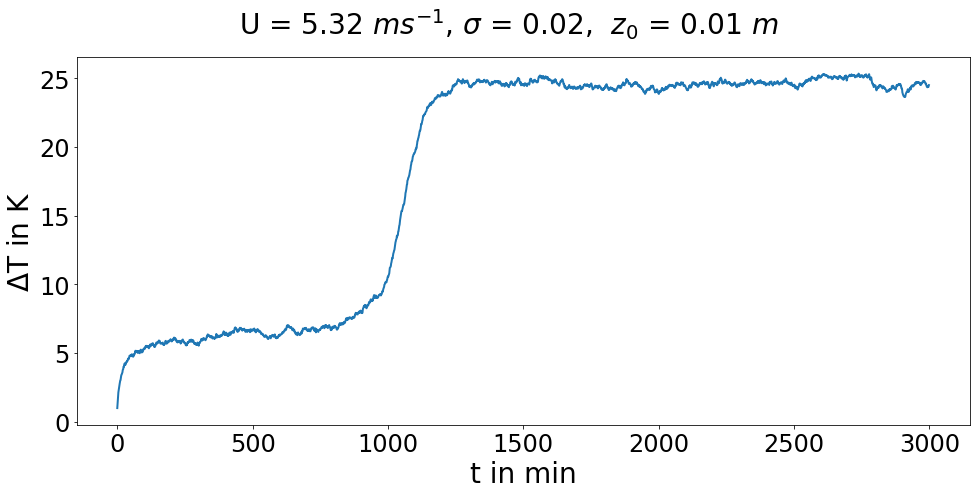

In [33]:
fig = plt.figure(figsize=(16,7))

title = 'U = ' + str(U) + ' $ms^{-1}$, '+ '$\sigma$ = '+ str(g(1,1)) + ', '+' $z_0$ = ' + str(z_0)+' $m$'
plt.suptitle(title, fontsize = 28)
plt.xlabel('t in min', fontsize = 28)
plt.ylabel('$\Delta$T in K', fontsize=28)

plt.tick_params(axis='both', which='major', labelsize=24)
plt.gcf().subplots_adjust(bottom=0.15)

plt.plot(resultfs, linewidth=2)  # short-tail
plt.savefig('domeC_1D_noise_close_bpoint.png')
#plt.plot(resultfl)  # long-tail
#plt.plot(resultfc)  # cut-off

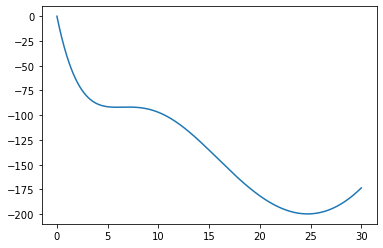

In [34]:
# underlying energy potential
x = np.linspace(0,30,1000)
plt.plot(x,FST(x))

#### **Additive noise on temperature inversion $\Delta T$ and wind speed $U$**

In [14]:
x0 = 12
U = 5.6
B = np.diag([0.25,0.11]) # intensity for independent brownian motion

def G(X,t):
    return B

def potential_sde_2d(x,u,t):
    dxdt = q/c_v - (l/c_v)*x - (rho*c_p*c_D/c_v)* u * x * np.exp(-C*x/pow(u,2) - pow((C*x/(2*pow(u,2))),2))
    return (dxdt)

def f(X, t):
    dXdt = np.array([potential_sde_2d(X[0], X[1], t), -0.5*(X[1]-U)])
    return dXdt

X0 = np.array([x0, U])
tspan = np.linspace(0.0, 36000.0,36000)
SDE_out = sdeint.itoint(f, G, X0, tspan)
#np.savetxt("SDE_out_DomeC_10000h_tempr.txt", SDE_out.T[0], fmt="%s")

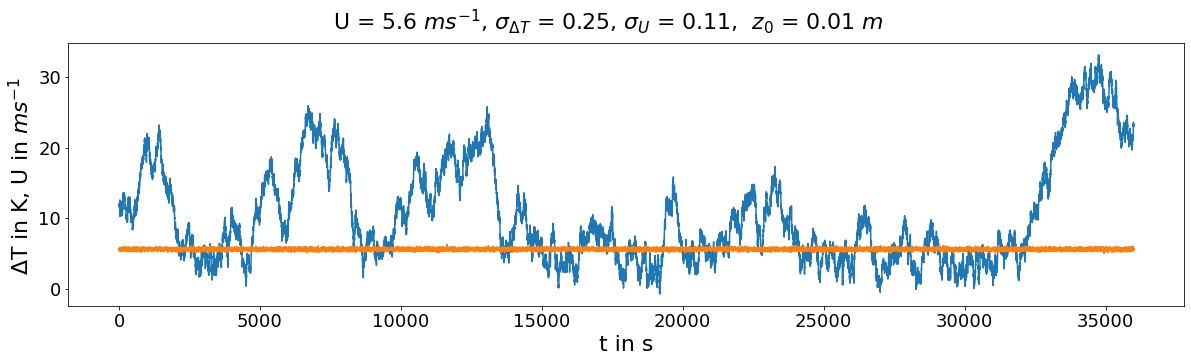

In [15]:
fig = plt.figure(figsize=(20,5))
title = 'U = ' + str(U) + ' $ms^{-1}$, '+ '$\sigma_{\Delta T}$ = '+ str(B[0][0]) + ', ' + '$\sigma_{U}$ = '+ str(B[1][1]) + ', ' + ' $z_0$ = ' + str(z_0)+' $m$'
plt.suptitle(title, fontsize = 22)
plt.ylabel('$\Delta$T in K, U in $ms^{-1}$ ', fontsize=22)
plt.xlabel('t in s', fontsize = 22)
plt.gcf().subplots_adjust(bottom=0.15)
plt.tick_params(axis='both', which='major', labelsize=18)

plt.plot(SDE_out)
#plt.savefig('DomeC_integrate_2D.png')

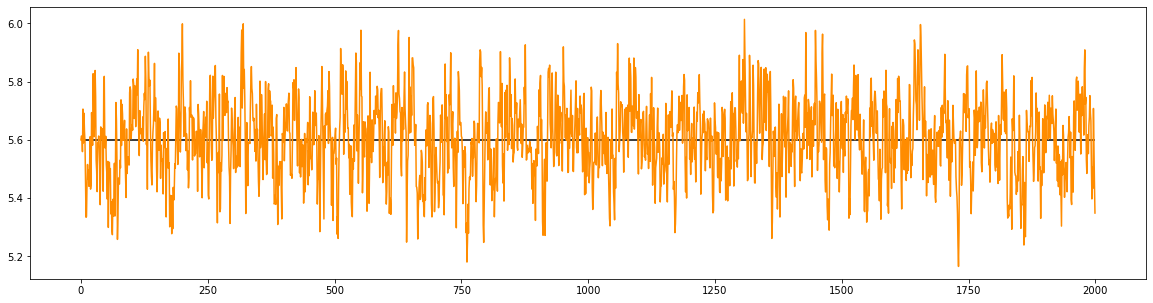

In [17]:
# wind speed
fig = plt.figure(figsize=(20,5))
plt.plot(SDE_out.T[1][:2000], color = 'darkorange')
plt.hlines(y=5.6,xmin=0,xmax=2000,color='black')

#### **Density plot of inversion strength states**

/home/anne/miniconda3/envs/bifurcations/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


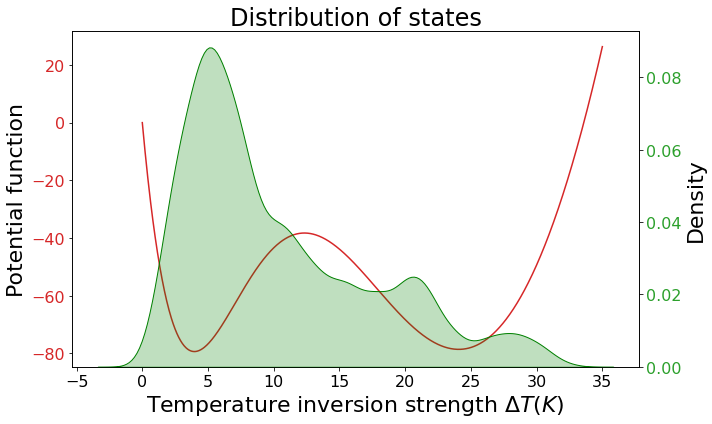

In [16]:

U=5.6
x = np.linspace(0,35,1000)
fig, ax1 = plt.subplots(figsize=(10,6))

# potential function plot
ax1.set_title('Distribution of states', fontsize=24)
color = 'tab:red'
ax1.set_xlabel('Temperature inversion strength $\Delta T (K)$', fontsize = 22)
ax1.set_ylabel('Potential function', fontsize = 22)
ax1.plot(x,FST(x), color=color) 
ax1.tick_params(axis='y', labelcolor=color, labelsize = 16)
ax1.tick_params(axis='x', labelsize = 16)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# density plot
color = 'tab:green'
ax2.set_ylabel('Density', fontsize = 22)  # we already handled the x-label with ax1
ax2 = sns.distplot(SDE_out.T[0], hist=False, color="g", kde_kws={"shade": True})
ax2.tick_params(axis='y', labelcolor=color, labelsize=16)
ax2.tick_params(axis='x', labelsize = 16)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

#plt.savefig('Distribution_long_run_025011_u56_10000h.png')